In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

from qtt.algorithms.functions import (gauss_ramsey, fit_gauss_ramsey, 
                                      plot_gauss_ramsey_fit)
from qutip import (basis, tensor, sigmaz, sigmax, sigmaz, sigmam, sigmap, 
                   mesolve, identity, Qobj, destroy, qeye, expect, parallel_map)

from qubit_zz_coupling.core import (setup_operators, solve_t1, solve_t2,
                                    plot_t1, plot_t2, rabi_results, make_n,
                                    ramsey_expectation_drive_both,
                                    ramsey_population_drive_both,
                                    ramsey_expectation_drive_sep,
                                    ramsey_population_drive_sep,
                                    rabi_expectation, make_3tensor)
from qubit_zz_coupling.utils import  f2w, fq_shift, make_population, ramsey


In [ ]:
USE_MP = True # Depends on system

# Define system parameters
SYSTEM_PARAMS_base = {
    "f_q1": 3.2,  # GHz, Qubit 1 frequency (3.2)
    "f_q2": 3.35,  # GHz, Qubit 2 frequency
    "f_tls": 3.2,  # GHz, TLS frequency (resonant with Qubit 1)
    "T1": {"q1": 200, "q2": 250, "tls": 5000},  # Relaxation rates
    "T2": {"q1": 150, "q2": 180, "tls": 3000},  # Dephasing rates
    "J_zz": 0.00, # Jzz coupling
    "J_tls": 0.00,  # GHz, Coupling strength between Qubit 1 and TLS
    "omega1": 2*np.pi * 0.01, # drive amplitude (sets π/2 duration)
    "omega2": 2*np.pi * 0.01, # drive amplitude (sets π/2 duration)
    "time_points": np.linspace(0, 300, 105),  # Time points in μs
    "ver1": True,
    "single": True
}

opts = {"nsteps": 1000000}

# Rabi Oscillation

In [10]:
# Get fresh settings
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

t=np.linspace(0,500,1000) #ns
w_d = f2w(SYSTEM_PARAMS["f_q1"]) # drive at q1 freq
omega = SYSTEM_PARAMS["omega1"]

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2, sm_q1, sm_q2 = setup_operators(SYSTEM_PARAMS)

my_cops = [c_ops[0],c_ops[3]]
res_ = rabi_results(t, w_d, omega, H, sx_q1, sz_q1, c_ops=my_cops, opts=opts, psi0=make_3tensor(0,1,1))

Text(0, 0.5, 'Excitation expectation value')

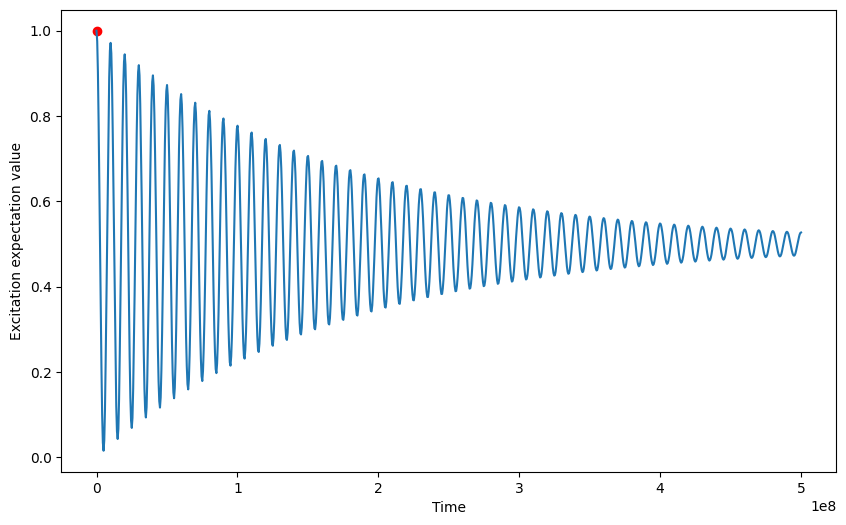

In [11]:
n = make_n(sm_q1)
res = expect(n, res_.states)
# rabi osc pi pulse
i=np.argmax(res)
#print("pi pulse:", t[i])

# prompt: plot res

fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.scatter(t[i]*1e6,res[i],color="red") #pi pulse peak
axes.plot(t*1e6, res)
axes.set_xlabel('Time')
axes.set_ylabel('Excitation expectation value')
#axes.set_title(f'Rabi Oscillation pulse={pi_pulse:.3f}');


In [5]:
# Get fresh settings
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

w_q1 = f2w(SYSTEM_PARAMS["f_q1"])

# Example sweep
taus      = np.linspace(0, 200, 201)
detunings = np.linspace(-0.2, +0.2, 3) * 2 * np.pi
t_p = np.pi / (2 * SYSTEM_PARAMS["omega1"])

opts = {"nsteps": 1000000}

psi0 = tensor(basis(2, 0), basis(2, 1), basis(2, 1))

def pm(t): # wrapper: define where used
    return ramsey_population_drive_sep(1, t, (w_d1, w_q1), t_p, SYSTEM_PARAMS, *setup_operators(SYSTEM_PARAMS), opts=opts, psi0=psi0)

data = {}
for delta in detunings:
    w_d1 = w_q1 + delta
    if  USE_MP:
        vals = list(parallel_map(pm,taus))
    else:
        #vals = [pm(tau) for tau in taus]
        vals = [ramsey_population_drive_sep(1, tau, (w_d1, w_d1), t_p, SYSTEM_PARAMS, *setup_operators(SYSTEM_PARAMS), opts=opts, psi0=psi0) for tau in taus]

    data[delta] = vals

plt.figure(figsize=(8, 5))
for delta, vals in data.items():
    plt.plot(taus, vals, label=f"Δ = {delta/(2*np.pi):.3f} GHz")
plt.xlabel("τ (ns)")
plt.ylabel("Population")
plt.title("Two-Qubit Ramsey Experiment with ZZ Coupling")
plt.legend()
plt.grid(True)
plt.show()

TypeError: ramsey_population_drive_sep() got multiple values for argument 'opts'

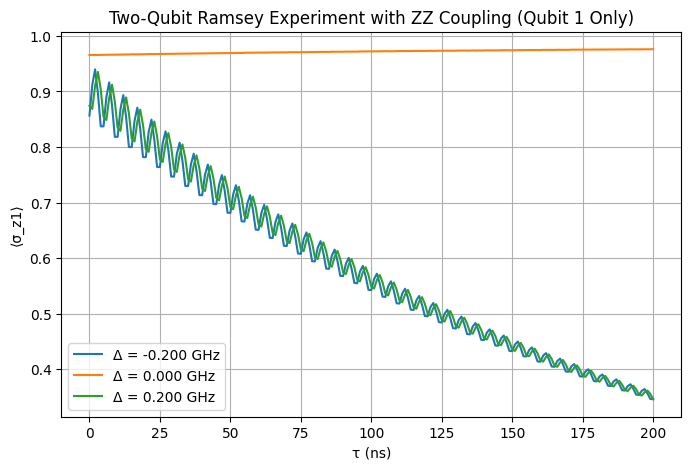

In [ ]:
plt.figure(figsize=(8, 5))
for delta, vals in data.items():
    # If vals is a list of tuples, extract only qubit 1 data:
    vals_q1 = [v[0] if isinstance(v, (tuple, list)) else v for v in vals]
    plt.plot(taus, vals_q1, label=f"Δ = {delta/(2*np.pi):.3f} GHz")
plt.xlabel("τ (ns)")
plt.ylabel("Population")
plt.title("Two-Qubit Ramsey Experiment with ZZ Coupling (Qubit 1 Only)")
plt.legend()
plt.grid(True)
plt.show()

# Q1 Single Drive and Fit

In [8]:
w_q = f2w(SYSTEM_PARAMS["f_q1"]) 
opts = {"nsteps": 1000000}

# Example sweep
taus      = np.linspace(0, 200, 201)
t_p = np.pi / (2 * SYSTEM_PARAMS["omega1"])

# wrapper
def pm(tau):
    return ramsey_population_drive_sep(1, tau, w_q, t_p, SYSTEM_PARAMS, *setup_operators(SYSTEM_PARAMS), opts=opts)

if  USE_MP:
    vals = list(parallel_map(pm,taus))
else:
    vals = [ramsey_population_drive_sep(1, tau, w_q, t_p, SYSTEM_PARAMS, *setup_operators(SYSTEM_PARAMS), opts=opts) for tau in taus]

[4.49745855e-05 3.07234767e+03 3.19898500e+00 1.26858368e+00
 9.76627974e-01]


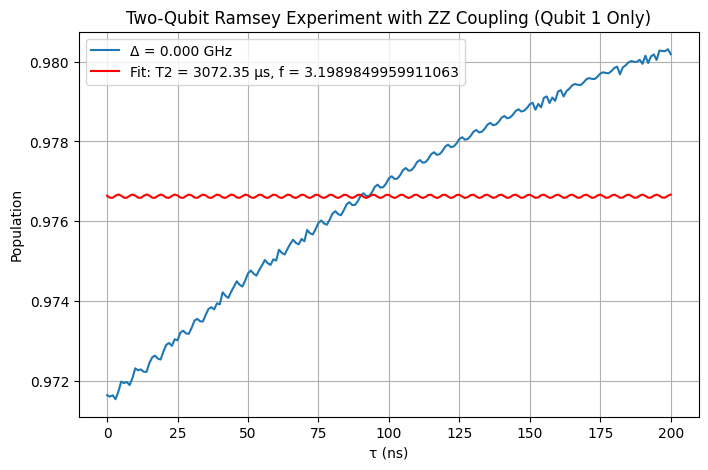

In [6]:
vals_q1 = (np.array([v[0] if isinstance(v, (tuple, list)) else v for v in vals]))

first_guess = [0.5, SYSTEM_PARAMS["T2"]["q1"], SYSTEM_PARAMS["f_q1"], 0.0, 0.5]

fit_par, _ = curve_fit(ramsey, taus, vals_q1, p0=first_guess)
print(fit_par)

plt.figure(figsize=(8, 5))

plt.plot(taus, vals_q1, label=f"Δ = {0/(2*np.pi):.3f} GHz")
plt.plot(taus, ramsey(taus, *fit_par), 'r-',
            label=f'Fit: T2 = {fit_par[1]:.2f} μs, f = {fit_par[2]}')
plt.xlabel("τ (ns)")
plt.ylabel("Population")
plt.title("Two-Qubit Ramsey Experiment with ZZ Coupling (Qubit 1 Only)")
plt.legend()
plt.grid(True)
plt.show()

# Q2 Single Drive and Fit

In [61]:
w_q = f2w(SYSTEM_PARAMS["f_q2"] + 0.0) 
opts = {"nsteps": 1000000}

# Example sweep
taus      = np.linspace(0, 200, 201)
t_p = np.pi / (2 * SYSTEM_PARAMS["omega2"])

# wrapper
def pm(tau):
    return ramsey_population_drive_sep(2, tau, w_q, t_p, SYSTEM_PARAMS, *setup_operators(SYSTEM_PARAMS), opts=opts)

if  USE_MP:
    vals = list(parallel_map(pm,taus))
else:
    vals = [ramsey_population_drive_sep(2, tau, w_q, t_p, SYSTEM_PARAMS, *setup_operators(SYSTEM_PARAMS), opts=opts) for tau in taus]

[-6.22836487e-02  7.96895231e+01  3.30011051e-01  1.20456011e+00
  9.17898704e-01]


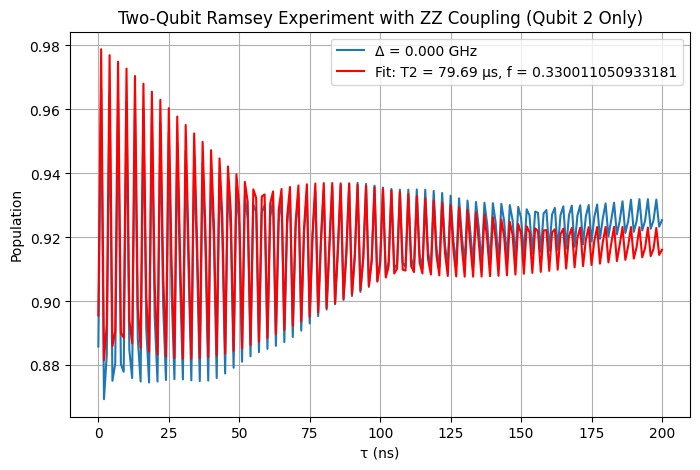

In [62]:
vals_q2 = (np.array([v[1] if isinstance(v, (tuple, list)) else v for v in vals]))

first_guess = [0.3, SYSTEM_PARAMS["T2"]["q2"], SYSTEM_PARAMS["f_q2"], 1.0, 0.4]
first_guess, _  = fit_gauss_ramsey(taus, vals_q2)

fit_par, _ = curve_fit(ramsey, taus, vals_q2, p0=first_guess)
print(fit_par)

plt.figure(figsize=(8, 5))

plt.plot(taus, vals_q2, label=f"Δ = {0/(2*np.pi):.3f} GHz")

ovr_samp = False
oversample = taus
if (ovr_samp):
    oversample = np.linspace(taus[0],taus[-1],10*len(taus))
plt.plot(oversample, ramsey(oversample, *fit_par), 'r-',
            label=f'Fit: T2 = {fit_par[1]:.2f} μs, f = {fit_par[2]}')

plt.xlabel("τ (ns)")
plt.ylabel("Population")
plt.title("Two-Qubit Ramsey Experiment with ZZ Coupling (Qubit 2 Only)")
plt.legend()
plt.grid(True)
plt.show()

# Drive Both

In [3]:
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()
SYSTEM_PARAMS["J_zz"] = 0.1
SYSTEM_PARAMS["J_tls"] = 0.05

In [4]:
w_q1 = f2w(SYSTEM_PARAMS["f_q1"] + 0.0) 
w_q2 = f2w(SYSTEM_PARAMS["f_q2"] + 0.1) 
opts = {"nsteps": 1000000}

# Example sweep
taus      = np.linspace(0, 200, 201)
t_p = np.pi / (2 * SYSTEM_PARAMS["omega1"])

# wrapper
def pm(tau):
    return ramsey_population_drive_both(tau, w_q1, w_q2, t_p, SYSTEM_PARAMS, *setup_operators(SYSTEM_PARAMS), opts=opts)

if  USE_MP:
    vals = list(parallel_map(pm,taus))
else:
    vals = [ramsey_population_drive_sep(tau, w_q1, w_q2, t_p, SYSTEM_PARAMS, *setup_operators(SYSTEM_PARAMS), opts=opts) for tau in taus]

[ 0.38942846 53.64131329  0.35003449 -4.81687051  0.48398221]


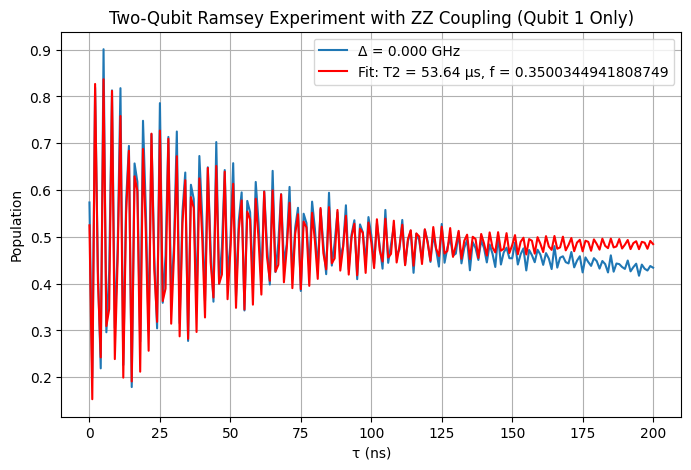

In [5]:
vals_q1 = (np.array([v[1] if isinstance(v, (tuple, list)) else v for v in vals]))

first_guess = [0.5, SYSTEM_PARAMS["T2"]["q1"], SYSTEM_PARAMS["f_q1"], 0.0, 0.5]
first_guess, _  = fit_gauss_ramsey(taus, vals_q1)

fit_par, _ = curve_fit(ramsey, taus, vals_q1, p0=first_guess)
print(fit_par)

plt.figure(figsize=(8, 5))

plt.plot(taus, vals_q1, label=f"Δ = {0/(2*np.pi):.3f} GHz")

ovr_samp = False
oversample = taus
if (ovr_samp):
    oversample = np.linspace(taus[0],taus[-1],10*len(taus))
plt.plot(oversample, ramsey(oversample, *fit_par), 'r-',
            label=f'Fit: T2 = {fit_par[1]:.2f} μs, f = {fit_par[2]}')

plt.xlabel("τ (ns)")
plt.ylabel("Population")
plt.title("Two-Qubit Ramsey Experiment with ZZ Coupling (Qubit 1 Only)")
plt.legend()
plt.grid(True)
plt.show()

[-1.46863590e-01  1.49436301e+02  3.70180994e-01 -2.49942142e+00
  4.94391828e-01]


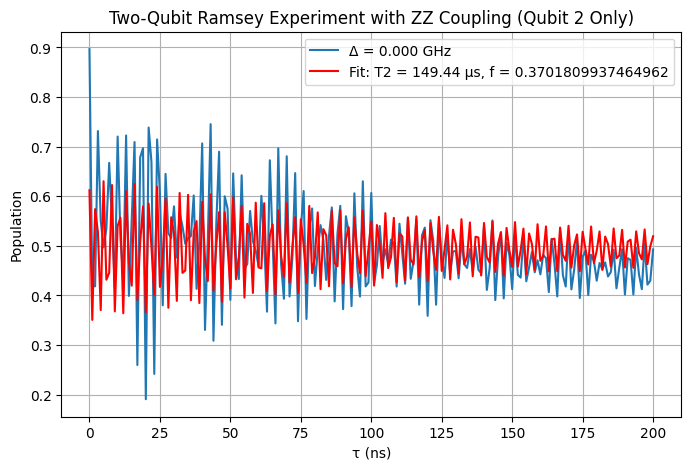

In [ ]:
vals_q2 = (np.array([v[0] if isinstance(v, (tuple, list)) else v for v in vals]))

first_guess = [0.3, SYSTEM_PARAMS["T2"]["q2"], SYSTEM_PARAMS["f_q2"], 1.0, 0.4]
first_guess, _  = fit_gauss_ramsey(taus, vals_q2)

fit_par, _ = curve_fit(ramsey, taus, vals_q2, p0=first_guess)
print(fit_par)

plt.figure(figsize=(8, 5))

plt.plot(taus, vals_q2, label=f"Δ = {0/(2*np.pi):.3f} GHz")

ovr_samp = False
oversample = taus
if (ovr_samp):
    oversample = np.linspace(taus[0],taus[-1],10*len(taus))
plt.plot(oversample, ramsey(oversample, *fit_par), 'r-',
            label=f'Fit: T2 = {fit_par[1]:.2f} μs, f = {fit_par[2]}')

plt.xlabel("τ (ns)")
plt.ylabel("Population")
plt.title("Two-Qubit Ramsey Experiment with ZZ Coupling (Qubit 2 Only)")
plt.legend()
plt.grid(True)
plt.show()

# Scan Q1

  0%|          | 0/10 [00:00<?, ?it/s]

[ -0.31534824 109.36189287   0.19998268  -2.35854721   0.69049061]


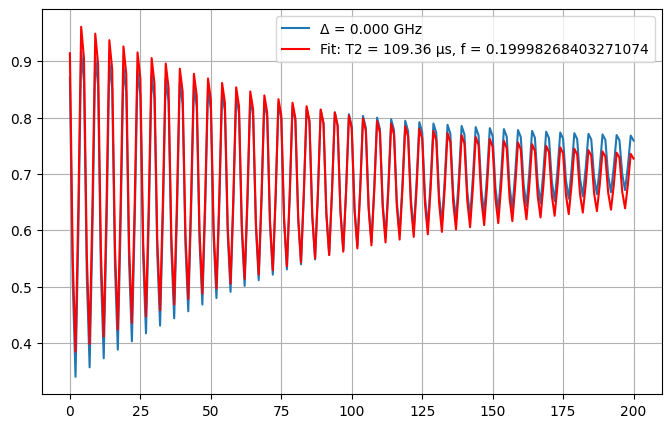

Error solving T2 for J_zz=0.0, J_tls=0.17777777777777778
[ 1.32042353e+01  1.67110896e+03  1.10059776e-04 -4.10076523e+00
  8.33785325e+00]


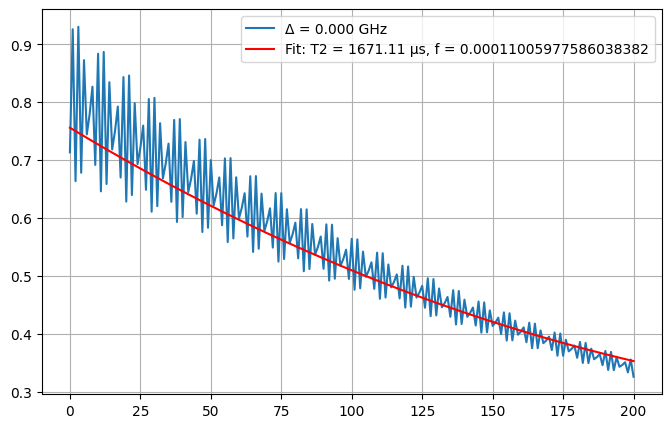

/home/jayamao/miniforge3/envs/qiskit/lib/python3.10/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
 10%|█         | 1/10 [00:17<02:35, 17.32s/it]

Error solving T2 for J_zz=0.08888888888888889, J_tls=0.0
[ 1.15824370e+00  1.85744968e+02  7.76513452e-05 -6.26778986e-01
  9.26936003e-03]


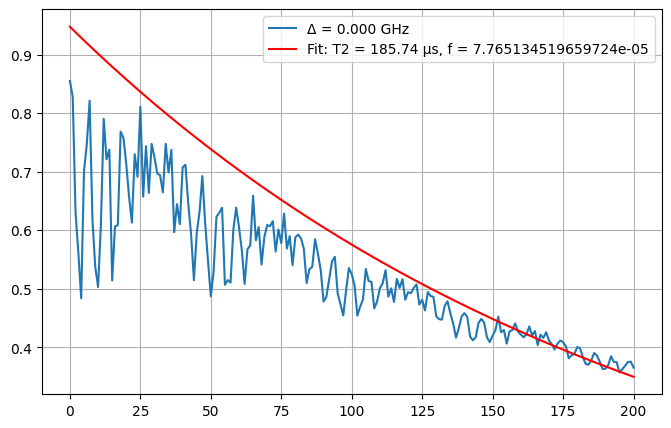

Error solving T2 for J_zz=0.08888888888888889, J_tls=0.17777777777777778
[ 0.19875323 90.47108519  0.47260846  0.15685354  0.51104482]


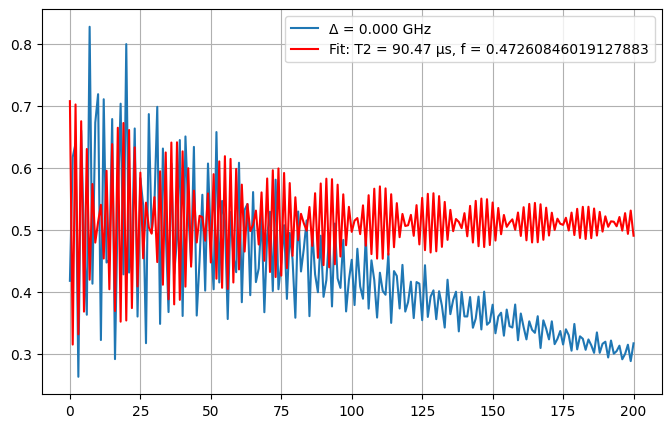

Error solving T2 for J_zz=0.08888888888888889, J_tls=0.7111111111111111
[ 1.18564128e+00  1.83420080e+02  8.33115095e-05 -6.64872435e-01
  1.23604908e-02]


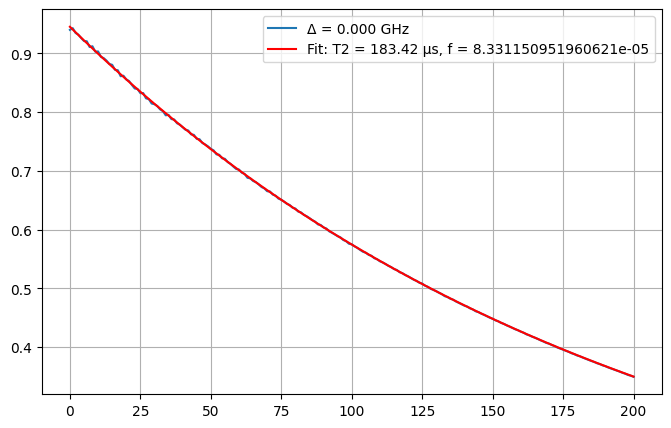

Error solving T2 for J_zz=0.08888888888888889, J_tls=0.8
[ 1.18564128e+00  1.83420080e+02  8.33115095e-05 -6.64872435e-01
  1.23604908e-02]


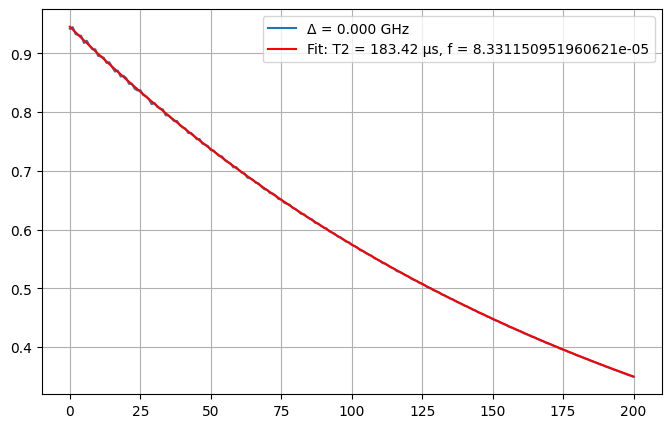

 20%|██        | 2/10 [00:35<02:22, 17.83s/it]

Error solving T2 for J_zz=0.17777777777777778, J_tls=0.0
[ 1.18564128e+00  1.83420080e+02  8.33115095e-05 -6.64872435e-01
  1.23604908e-02]


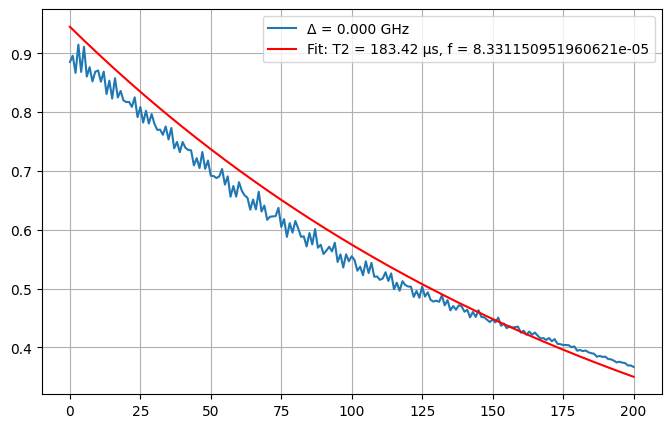

/home/jayamao/miniforge3/envs/qiskit/lib/python3.10/site-packages/lmfit/minimizer.py:819: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/home/jayamao/miniforge3/envs/qiskit/lib/python3.10/site-packages/lmfit/minimizer.py:826: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/home/jayamao/miniforge3/envs/qiskit/lib/python3.10/site-packages/uncertainties/core.py:116: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


Error solving T2 for J_zz=0.17777777777777778, J_tls=0.35555555555555557
[ 2.89043282e-01 -8.90981301e+05 -1.01250075e-03 -2.00252305e+01
  5.36084404e-01]


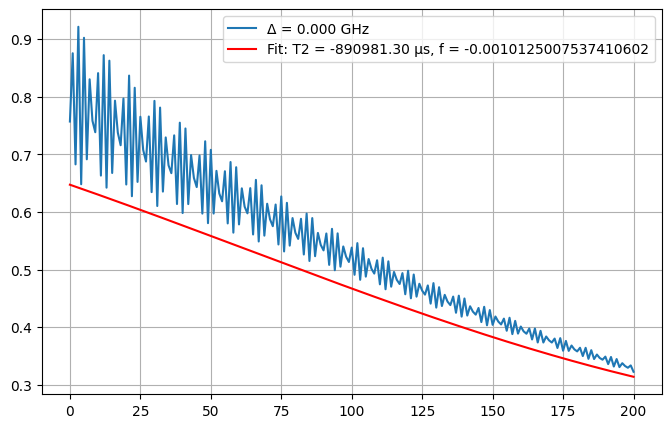

 30%|███       | 3/10 [00:52<02:01, 17.36s/it]

Error solving T2 for J_zz=0.26666666666666666, J_tls=0.17777777777777778
[ 9.40340022e-01  2.00309268e+02 -1.06271655e-06 -5.63168908e+00
  6.88627310e-02]


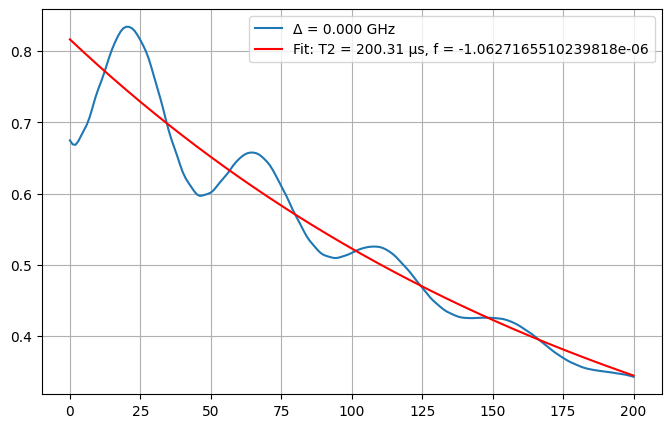

Error solving T2 for J_zz=0.26666666666666666, J_tls=0.35555555555555557
[-0.35372592 65.3204151   0.20007263 -2.42572681  0.4596598 ]


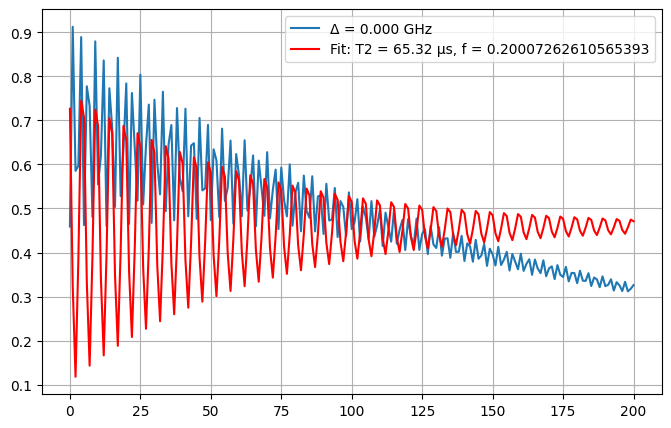

Error solving T2 for J_zz=0.26666666666666666, J_tls=0.4444444444444445
[-0.35372592 65.3204151   0.20007263 -2.42572681  0.4596598 ]


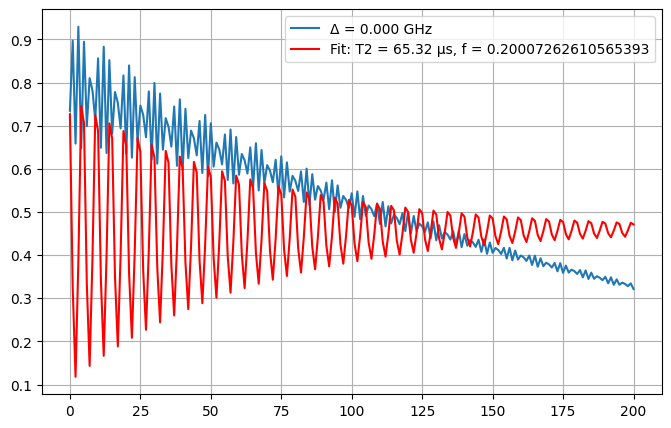

Error solving T2 for J_zz=0.26666666666666666, J_tls=0.5333333333333333
[-0.35372592 65.3204151   0.20007263 -2.42572681  0.4596598 ]


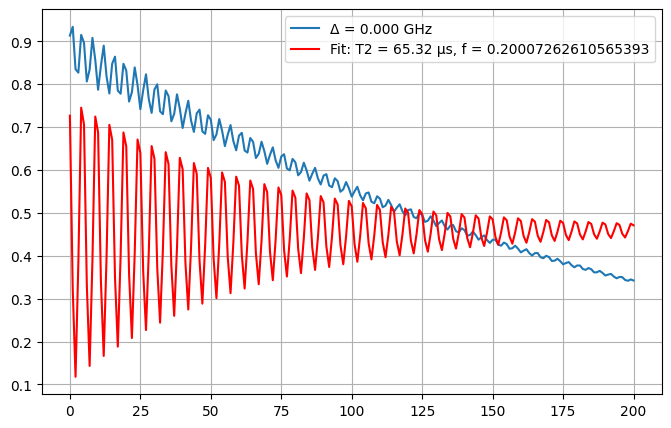

 40%|████      | 4/10 [01:08<01:42, 17.04s/it]

Error solving T2 for J_zz=0.35555555555555557, J_tls=0.17777777777777778
[ 1.14146514e+00  1.94498701e+02  8.75732069e-07 -7.59321530e-01
  5.04835863e-02]


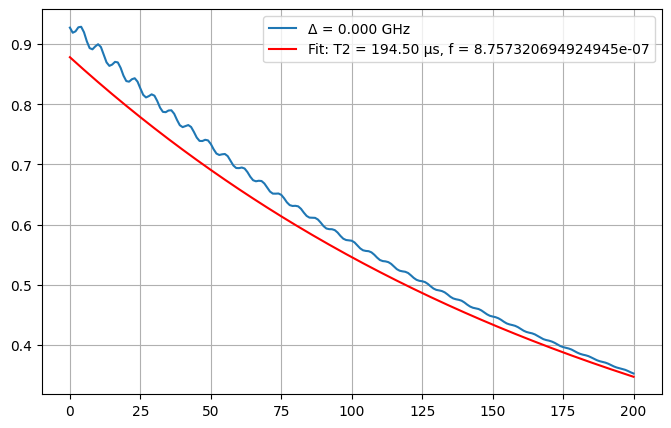

Error solving T2 for J_zz=0.35555555555555557, J_tls=0.26666666666666666
[ 1.14146514e+00  1.94498701e+02  8.75732069e-07 -7.59321530e-01
  5.04835863e-02]


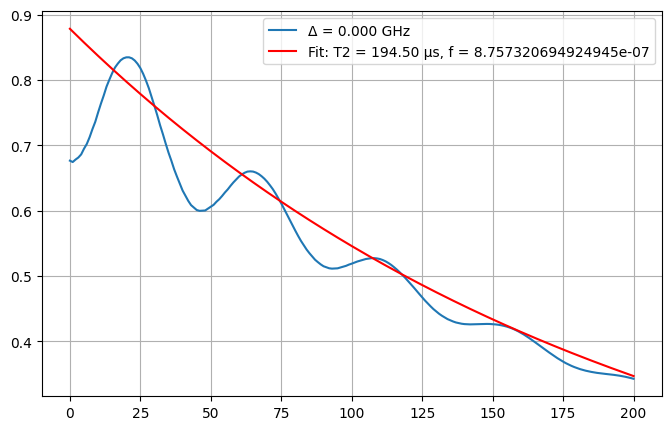

Error solving T2 for J_zz=0.35555555555555557, J_tls=0.5333333333333333
[ 3.20341717e-01 -1.86459715e+06 -1.06334832e-03  1.76273315e+01
  5.90498134e-01]


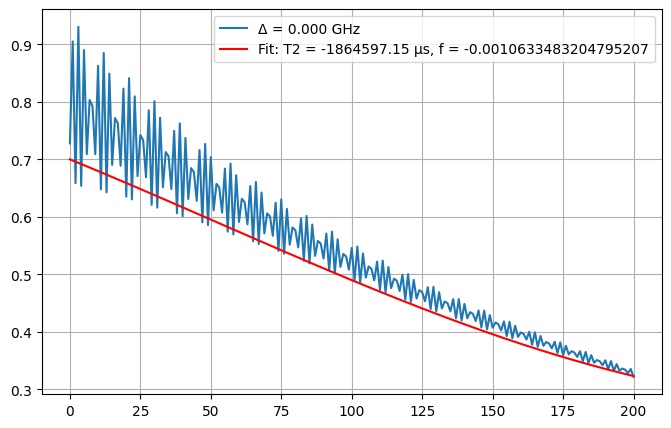

 50%|█████     | 5/10 [01:24<01:23, 16.67s/it]

Error solving T2 for J_zz=0.4444444444444445, J_tls=0.08888888888888889
[ 1.39110962e+00  1.99058161e+02 -3.07332887e-07 -8.47664390e-01
  1.49922814e-02]


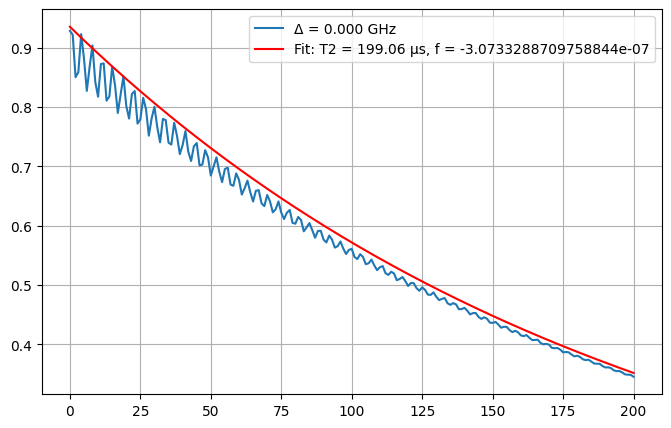

Error solving T2 for J_zz=0.4444444444444445, J_tls=0.17777777777777778
[ 1.39110962e+00  1.99058161e+02 -3.07332887e-07 -8.47664390e-01
  1.49922814e-02]


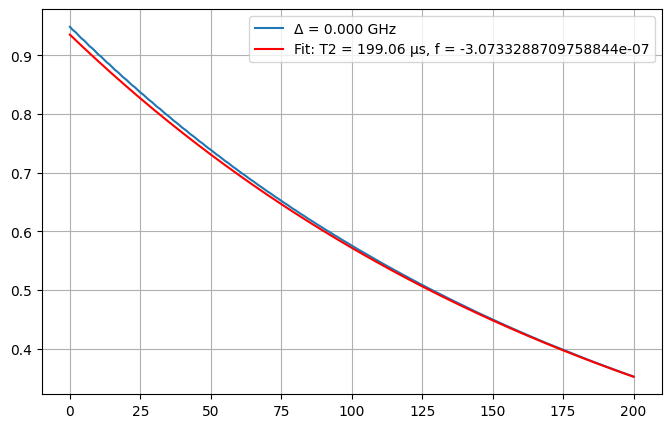

Error solving T2 for J_zz=0.4444444444444445, J_tls=0.35555555555555557
[9.32745524e+00 3.64666833e+02 5.55498236e-05 1.51816138e+00
 4.45690590e-01]


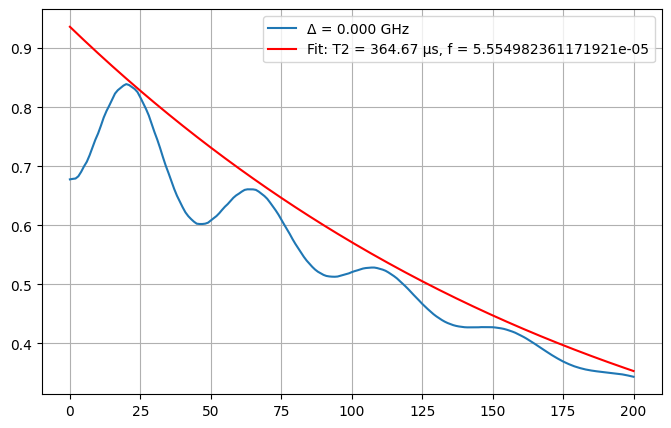

Error solving T2 for J_zz=0.4444444444444445, J_tls=0.5333333333333333
[-0.33567948 65.96243613  0.20008686 -2.43028169  0.46945842]


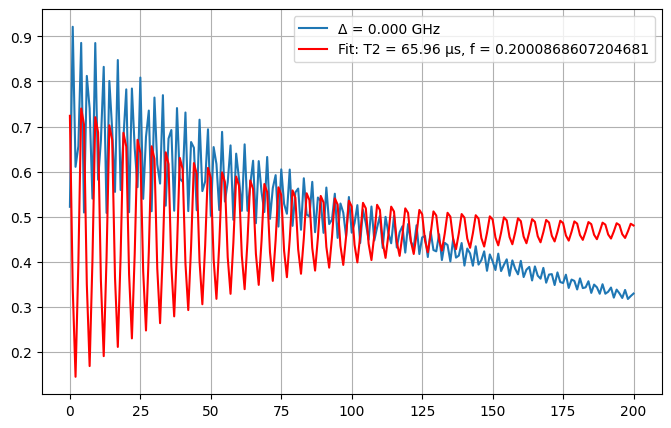

 60%|██████    | 6/10 [01:41<01:06, 16.61s/it]

Error solving T2 for J_zz=0.5333333333333333, J_tls=0.26666666666666666
[ 1.78929311e+00  1.80566015e+02  4.65174773e-05 -1.02403554e+00
  1.40345312e-02]


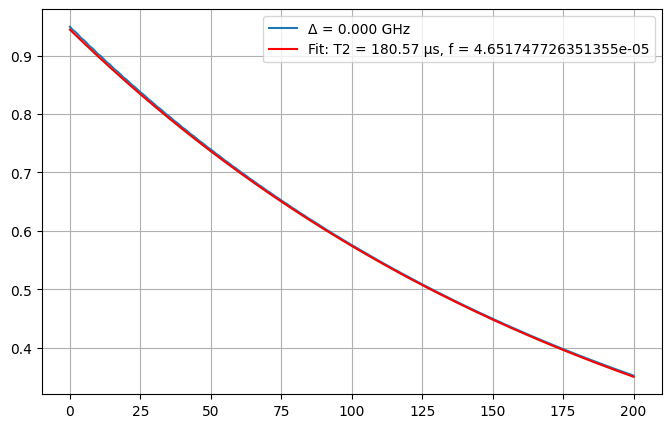

Error solving T2 for J_zz=0.5333333333333333, J_tls=0.35555555555555557
[ 1.78929311e+00  1.80566015e+02  4.65174773e-05 -1.02403554e+00
  1.40345312e-02]


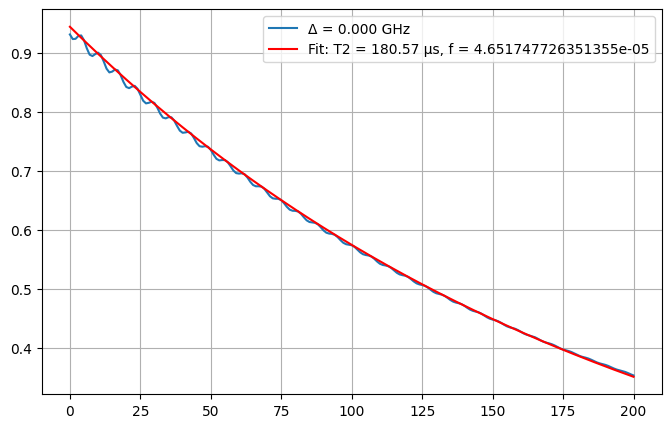

Error solving T2 for J_zz=0.5333333333333333, J_tls=0.4444444444444445
[ 1.78929311e+00  1.80566015e+02  4.65174773e-05 -1.02403554e+00
  1.40345312e-02]


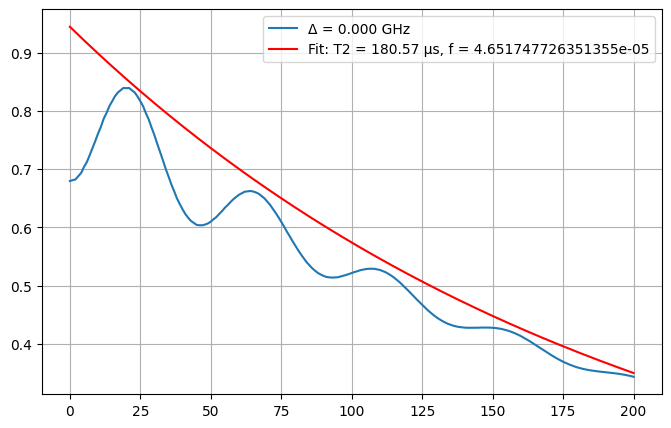

Error solving T2 for J_zz=0.5333333333333333, J_tls=0.6222222222222222
[-0.3316713  65.7021948   0.20009947 -2.43275     0.47231558]


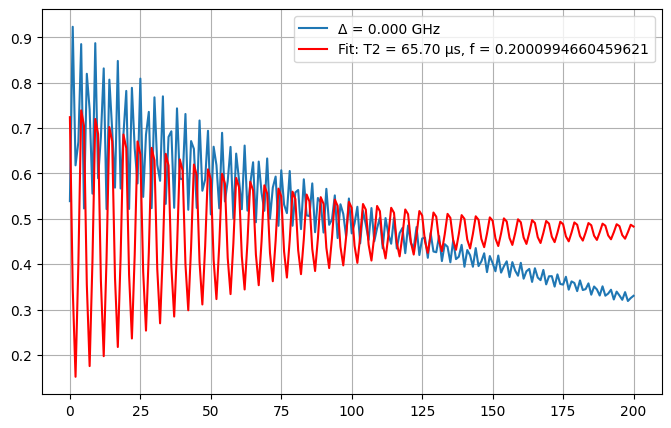

Error solving T2 for J_zz=0.5333333333333333, J_tls=0.7111111111111111
[-0.3316713  65.7021948   0.20009947 -2.43275     0.47231558]


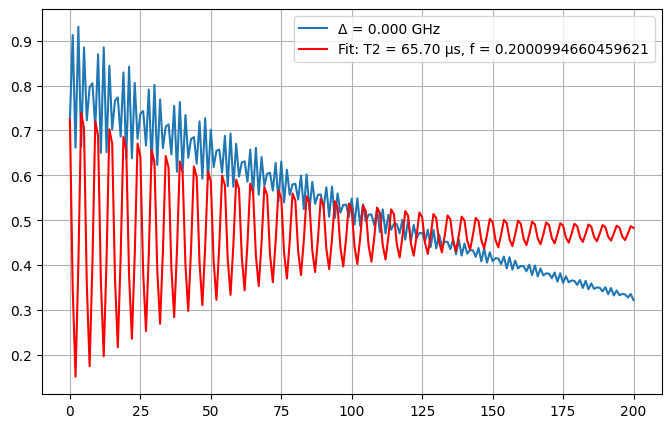

 70%|███████   | 7/10 [01:57<00:49, 16.56s/it]

Error solving T2 for J_zz=0.6222222222222222, J_tls=0.35555555555555557
[ 1.72497106e+00  1.79984104e+02  5.02673499e-05 -1.00167109e+00
  1.47542685e-02]


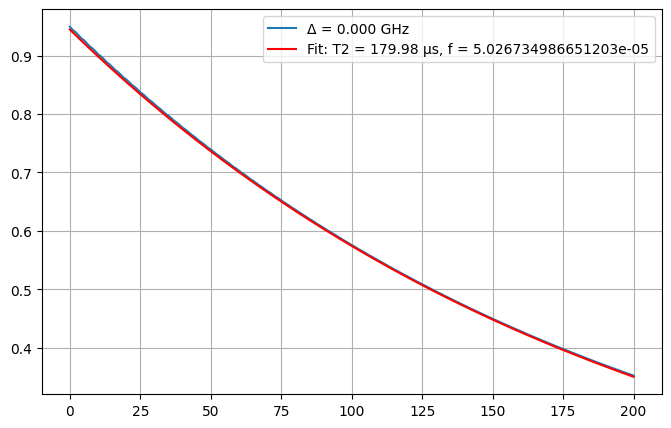

Error solving T2 for J_zz=0.6222222222222222, J_tls=0.5333333333333333
[1.68763248e+01 3.65243191e+02 3.10675285e-05 1.54221076e+00
 4.55505758e-01]


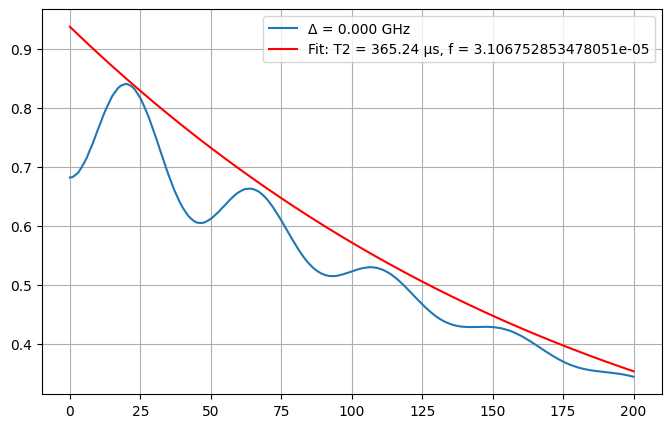

Error solving T2 for J_zz=0.6222222222222222, J_tls=0.8
[-4.01742006e-01 -1.98699136e+06 -9.23183443e-04  2.05682006e+01
  6.67298854e-01]


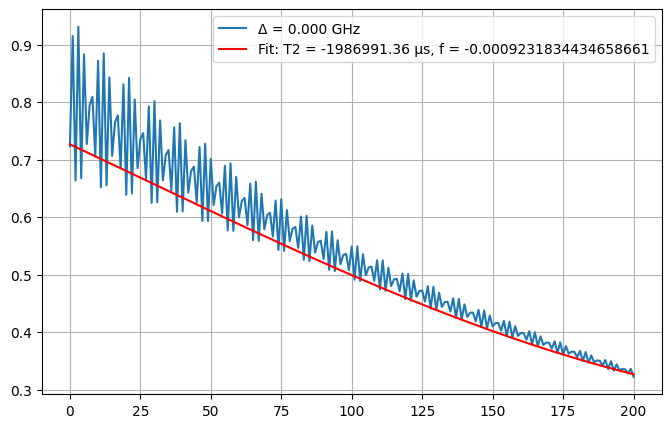

 80%|████████  | 8/10 [02:14<00:33, 16.65s/it]

Error solving T2 for J_zz=0.7111111111111111, J_tls=0.0
[-4.01742006e-01 -1.98699136e+06 -9.23183443e-04  2.05682006e+01
  6.67298854e-01]


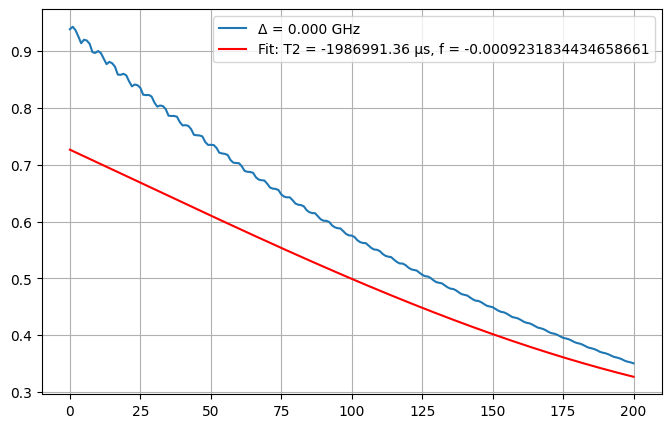

Error solving T2 for J_zz=0.7111111111111111, J_tls=0.4444444444444445
[ 1.68118000e+00  1.79227882e+02  5.47407030e-05 -9.85185753e-01
  1.49719700e-02]


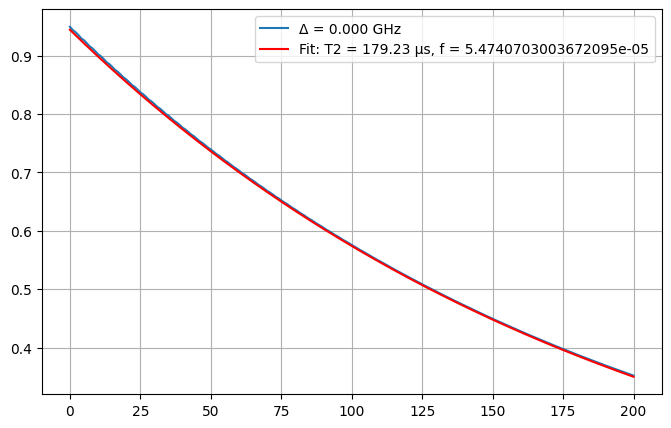

Error solving T2 for J_zz=0.7111111111111111, J_tls=0.5333333333333333
[ 1.68118000e+00  1.79227882e+02  5.47407030e-05 -9.85185753e-01
  1.49719700e-02]


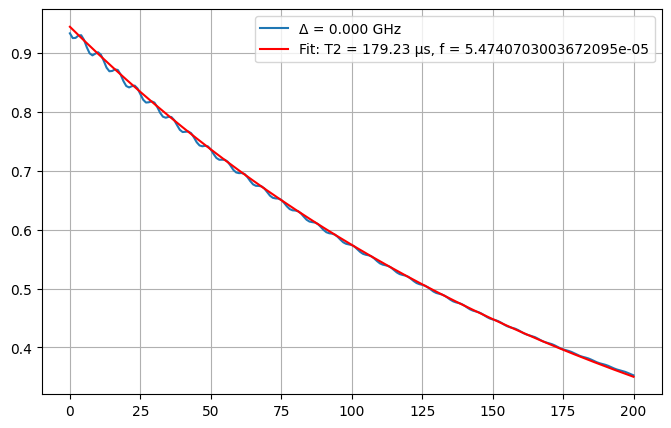

Error solving T2 for J_zz=0.7111111111111111, J_tls=0.6222222222222222
[ 1.68118000e+00  1.79227882e+02  5.47407030e-05 -9.85185753e-01
  1.49719700e-02]


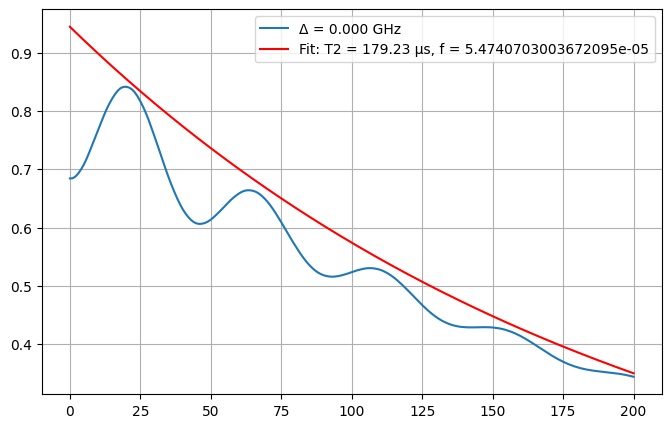

Error solving T2 for J_zz=0.7111111111111111, J_tls=0.8
[-0.32379737 65.60332185  0.20011176 -2.4311639   0.47594149]


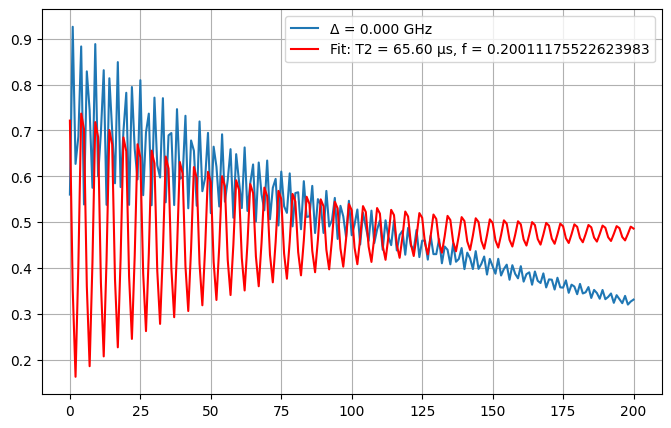

 90%|█████████ | 9/10 [02:31<00:16, 16.83s/it]

Error solving T2 for J_zz=0.8, J_tls=0.0
[-0.32379737 65.60332185  0.20011176 -2.4311639   0.47594149]


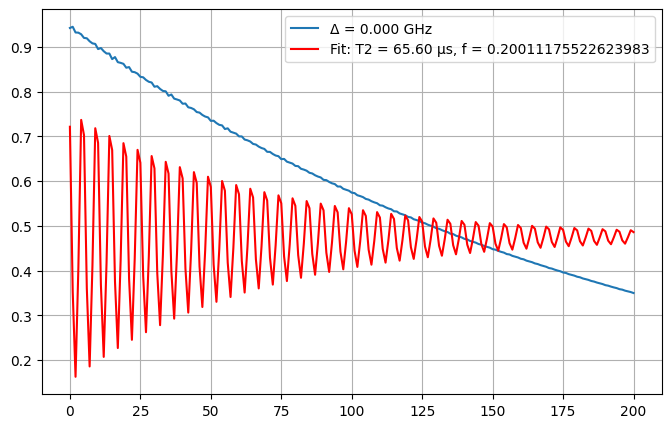

Error solving T2 for J_zz=0.8, J_tls=0.5333333333333333
[ 1.68645845e+00  1.77843485e+02  5.94830476e-05 -9.87366310e-01
  1.50343305e-02]


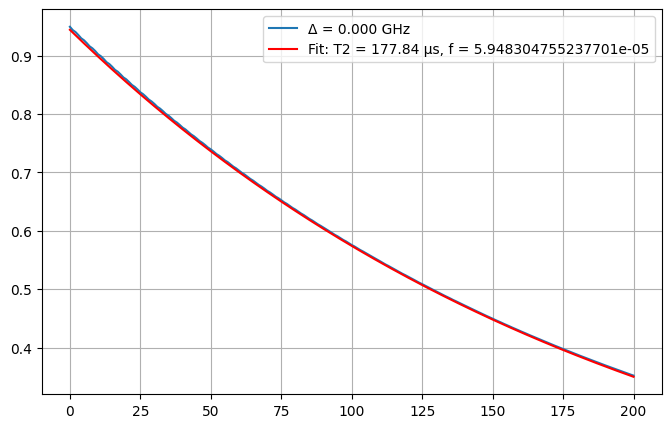

Error solving T2 for J_zz=0.8, J_tls=0.6222222222222222
[ 1.68645845e+00  1.77843485e+02  5.94830476e-05 -9.87366310e-01
  1.50343305e-02]


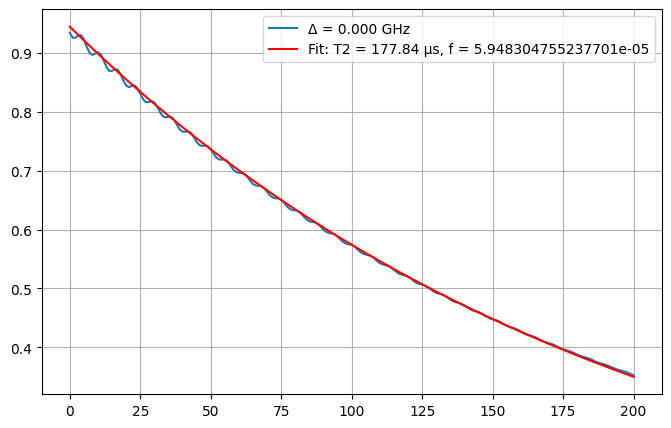

Error solving T2 for J_zz=0.8, J_tls=0.7111111111111111
[ 1.68645845e+00  1.77843485e+02  5.94830476e-05 -9.87366310e-01
  1.50343305e-02]


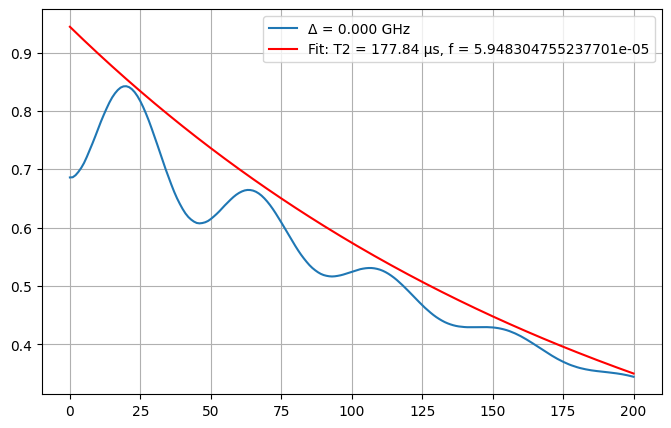

100%|██████████| 10/10 [02:49<00:00, 16.99s/it]


In [12]:

# Define parameter ranges
Jzz_vals = np.linspace(0.00, 0.8, 10)
JTLS_vals = np.linspace(0.00, 0.8, 10)
T2_matrix = np.zeros((len(Jzz_vals), len(JTLS_vals)))

# Base system parameters (without Jzz and JTLS)
base_params = SYSTEM_PARAMS_base.copy()

print_one = True
for i, Jzz in enumerate(tqdm(Jzz_vals)):
    for j, JTLS in enumerate(JTLS_vals):

        # Update parameters for this scan
        params = base_params.copy()
        params["J_zz"] = Jzz
        params["J_tls"] = JTLS

        # run exp
        w_q1 = f2w(params["f_q1"] + 0.05) 
        w_q2 = f2w(params["f_q2"] + 0.1) 
        opts = {"nsteps": 1000000}

        # Example sweep
        taus      = np.linspace(0, 200, 201)
        t_p = np.pi / (2 * params["omega1"])

        # wrapper
        def pm(tau):
            return ramsey_population_drive_both(tau, w_q1, w_q2, t_p, params, *setup_operators(params), opts=opts)

        if  USE_MP:
            vals = list(parallel_map(pm,taus))
        else:
            vals = [ramsey_population_drive_both(tau, w_q1, w_q2, t_p, params, *setup_operators(params), opts=opts) for tau in taus]

        # Solve T2 and store the fitted T2 value
        vals_q1 = (np.array([v[0] if isinstance(v, (tuple, list)) else v for v in vals]))

        try:
            first_guess = [0.5, params["T2"]["q1"], params["f_q1"], 0.0, 0.5]
            first_guess, _  = fit_gauss_ramsey(taus, vals_q1)

            fit_par, _ = curve_fit(ramsey, taus, vals_q1, p0=first_guess)
        except:
            print(f"Error solving T2 for J_zz={Jzz}, J_tls={JTLS}")
            print_one = True 
  
        if print_one:
            print(fit_par)
            print_one = False
            plt.figure(figsize=(8, 5))
            plt.plot(taus, vals_q1, label=f"Δ = {0/(2*np.pi):.3f} GHz")
            plt.plot(taus, ramsey(taus, *fit_par), 'r-',
            label=f'Fit: T2 = {fit_par[1]:.2f} μs, f = {fit_par[2]}')
            plt.legend()
            plt.grid(True)
            plt.show()

        #if do_print:
        #    plot_t2(H, psi0, tlist, c_ops, [sx_q1], fit_par, "Qubit 1", params)
        #    do_print = False

        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter
            




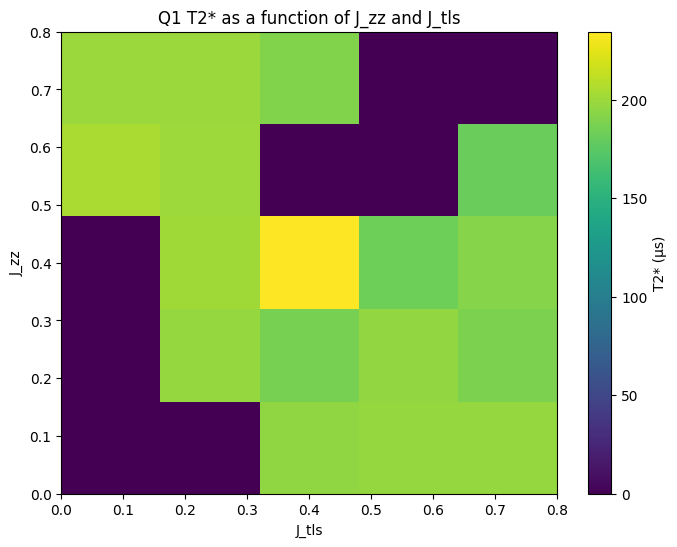

In [11]:
# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[JTLS_vals[0], JTLS_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('J_tls')
plt.ylabel('J_zz')
plt.title('Q1 T2* as a function of J_zz and J_tls')
plt.show()

In [9]:
T2_matrix

array([[52.56264867, 52.56264867, 52.56264867, 52.56264867, 52.56264867],
       [52.56264867, 52.56264867, 52.56264867, 52.56264867, 52.56264867],
       [52.56264867, 52.56264867, 52.56264867, 52.56264867, 52.56264867],
       [52.56264867, 52.56264867, 52.56264867, 52.56264867, 52.56264867],
       [52.56264867, 52.56264867, 52.56264867, 52.56264867, 52.56264867]])

# test rabi

In [8]:
# Get fresh settings
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

w_q1 = f2w(SYSTEM_PARAMS["f_q1"])

# Example sweep
taus      = np.linspace(0, 200, 201)
detunings = np.linspace(-0.2, +0.2, 3) * 2 * np.pi
t_p = np.pi / (2 * SYSTEM_PARAMS["omega1"])

opts = {"nsteps": 1000000}

psi0 = tensor(basis(2, 0), basis(2, 1), basis(2, 1))

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(SYSTEM_PARAMS)
psi0 = make_3tensor(1,0,0)

def pm(t): # wrapper: define where used
    return rabi_expectation(t, w_d1, SYSTEM_PARAMS["omega1"], H, sx_q1, sz_q1, c_ops=c_ops, opts=opts, psi0=psi0)

data = {}
for delta in detunings:
    w_d1 = w_q1 + delta
    if  USE_MP:
        vals = list(parallel_map(pm,taus))
    else:
        vals = [pm(tau) for tau in taus]

    data[delta] = vals



/home/jayamao/miniforge3/envs/qiskit/lib/python3.10/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/home/jayamao/miniforge3/envs/qiskit/lib/python3.10/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/home/jayamao/miniforge3/envs/qiskit/lib/python3.10/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/home/jayamao/miniforge3/envs/qiskit/lib/python3.10/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/home/jayamao/miniforge3/envs/qiskit/lib/python3.10/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/home/jayamao/miniforge3/envs/qiskit/lib/python3.10/site-pac

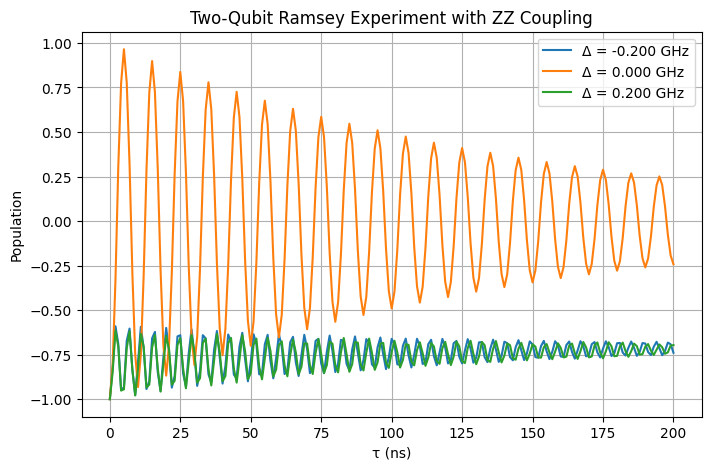

In [9]:
plt.figure(figsize=(8, 5))
for delta, vals in data.items():
    plt.plot(taus, vals, label=f"Δ = {delta/(2*np.pi):.3f} GHz")
plt.xlabel("τ (ns)")
plt.ylabel("Population")
plt.title("Two-Qubit Ramsey Experiment with ZZ Coupling")
plt.legend()
plt.grid(True)
plt.show()